<a href="https://colab.research.google.com/github/frankwillard/Jeopardy-Question-Answering/blob/main/Copy_of_Jeopardy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
jeopardy_data = pd.read_csv('combined_season1-39.tsv', sep='\t')

In [ ]:
len(jeopardy_data)

468317

## Preprocessing

In [ ]:
jeopardy_data['category'].value_counts()[:20].index

Index(['SCIENCE', 'AMERICAN HISTORY', 'LITERATURE', 'HISTORY', 'POTPOURRI',
       'SPORTS', 'WORD ORIGINS', 'WORLD GEOGRAPHY', 'BUSINESS & INDUSTRY',
       'RELIGION', 'WORLD HISTORY', 'TRANSPORTATION', 'ANIMALS', 'ART',
       'U.S. CITIES', 'BOOKS & AUTHORS', 'BODIES OF WATER', 'GEOGRAPHY',
       'BEFORE & AFTER', 'U.S. HISTORY'],
      dtype='object', name='category')

Want to remove certain categories (e.g. before and after, word origins)

In [ ]:
categories_to_test = list(jeopardy_data['category'].value_counts()[:20].index)

In [ ]:
categories_to_test = ['SCIENCE',
      'AMERICAN HISTORY',
      'LITERATURE',
      'HISTORY',
      # 'POTPOURRI',
      'SPORTS',
      # 'WORD ORIGINS',
      'WORLD GEOGRAPHY',
      'BUSINESS & INDUSTRY',
      'RELIGION',
      'WORLD HISTORY',
      'TRANSPORTATION',
      # 'ANIMALS',
      'ART',
      'U.S. CITIES',
      'BOOKS & AUTHORS',
      'BODIES OF WATER',
      'GEOGRAPHY',
      # 'BEFORE & AFTER',
      'U.S. HISTORY']

In [ ]:
jeopardy_categorized = jeopardy_data[jeopardy_data['category'].isin(categories_to_test)]

In [ ]:
jeopardy_categorized

,round,clue_value,daily_double_value,category,comments,answer,question,air_date,notes
57,1,100,0,TRANSPORTATION,NaN,"Type of auto engine, or a tomato cocktail",V8,1984-09-11,NaN
58,1,200,0,TRANSPORTATION,NaN,"Lindbergh was not first to fly the Atlantic, b...",solo,1984-09-11,NaN
59,1,300,0,TRANSPORTATION,NaN,"Derived from words ""American"", ""travel"", & ""tr...",Amtrak,1984-09-11,NaN
60,1,400,0,TRANSPORTATION,NaN,"London's, not New York's, was the first ever b...",the underground (or the metro or subway system),1984-09-11,NaN
61,1,500,0,TRANSPORTATION,NaN,"Changing lines, you could have at one time rid...",streetcars,1984-09-11,NaN
...,...,...,...,...,...,...,...,...,...
467885,2,400,0,HISTORY,NaN,A participant in this Boston Harbor event said...,the Boston Tea Party,2023-07-19,NaN
467886,2,800,0,HISTORY,NaN,In the 16th century an African man in Japan na...,Samurai,2023-07-19,NaN
467887,2,1200,0,HISTORY,NaN,"Oddly, the names of the agents involved in thi...",the XYZ Affair,2023-07-19,NaN
467888,2,1600,0,HISTORY,NaN,This political organization was founded by Hue...,the Black Panthers,2023-07-19,NaN


In [ ]:
data = jeopardy_categorized.copy()

In [ ]:
data['features'] = data['answer'] # data['category'] + ' ' + data['answer']

In [ ]:
# Tokenize text
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['features'])

In [ ]:
# Encode the questions as labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['question'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
# Initialize and train the Naive Bayes classifier
start = time.time()
model = MultinomialNB()
model.fit(X_train, y_train)
print(f"Trained in {time.time() - start} seconds")

Trained in 7.434218645095825 seconds


In [ ]:
y_pred_train = model.predict(X_train)

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7641677461139896


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.06411917098445596


In [ ]:
def rank_questions(category, answer):
    input_features = vectorizer.transform([f"{category} {answer}"])
    probabilities = model.predict_proba(input_features)[0]
    question_indices = probabilities.argsort()[::-1]  # Sort by probability
    ranked_questions = label_encoder.inverse_transform(question_indices)

    return pd.DataFrame({
        'Question': ranked_questions,
        'Probability': sorted(probabilities, reverse=True)
    })


In [ ]:
ranked_questions = rank_questions('HISTORY', 'Who was the first President of the United States?')
print(ranked_questions.head())

                 Question  Probability
0    Eleanor of Aquitaine     0.018669
1           Salvador Dali     0.014417
2           Andre Malraux     0.010955
3  Germany, Italy & Japan     0.010512
4               Mel Blanc     0.010004


## Embedding Space (TF-IDF)

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
len(train_data)

12352

In [ ]:
for category in categories_to_test:
  print(category, len(train_data[train_data['category'] == category]))

SCIENCE 1126
AMERICAN HISTORY 964
LITERATURE 959
HISTORY 931
SPORTS 845
WORLD GEOGRAPHY 768
BUSINESS & INDUSTRY 788
RELIGION 758
WORLD HISTORY 731
TRANSPORTATION 731
ART 651
U.S. CITIES 661
BOOKS & AUTHORS 621
BODIES OF WATER 613
GEOGRAPHY 596
U.S. HISTORY 609


In [ ]:
len(test_data)

3088

In [ ]:
for category in categories_to_test:
  print(category, len(test_data[test_data['category'] == category]))

SCIENCE 255
AMERICAN HISTORY 252
LITERATURE 221
HISTORY 236
SPORTS 250
WORLD GEOGRAPHY 204
BUSINESS & INDUSTRY 176
RELIGION 180
WORLD HISTORY 203
TRANSPORTATION 163
ART 183
U.S. CITIES 146
BOOKS & AUTHORS 157
BODIES OF WATER 162
GEOGRAPHY 163
U.S. HISTORY 137


In [6]:
from scipy.stats import binom_test

# Updated sample sizes for each category
sample_sizes = {
    "SCIENCE": 255, "AMERICAN HISTORY": 252, "LITERATURE": 221, "HISTORY": 236,
    "SPORTS": 250, "WORLD GEOGRAPHY": 204, "BUSINESS & INDUSTRY": 176, "RELIGION": 180,
    "WORLD HISTORY": 203, "TRANSPORTATION": 163, "ART": 183, "U.S. CITIES": 146,
    "BOOKS & AUTHORS": 157, "BODIES OF WATER": 162, "GEOGRAPHY": 163, "U.S. HISTORY": 137
}

# Accuracy percentages from the table
tfidf_accuracies = {
    "SCIENCE": 9.8, "AMERICAN HISTORY": 15.5, "LITERATURE": 15.8, "HISTORY": 17.4,
    "SPORTS": 7.6, "WORLD GEOGRAPHY": 20.6, "BUSINESS & INDUSTRY": 13.1, "RELIGION": 21.7,
    "WORLD HISTORY": 13.3, "TRANSPORTATION": 11.7, "ART": 18.6, "U.S. CITIES": 21.9,
    "BOOKS & AUTHORS": 15.9, "BODIES OF WATER": 25.3, "GEOGRAPHY": 14.7, "U.S. HISTORY": 15.3
}

bert_accuracies = {
    "SCIENCE": 8.6, "AMERICAN HISTORY": 15.1, "LITERATURE": 6.3, "HISTORY": 16.1,
    "SPORTS": 6.4, "WORLD GEOGRAPHY": 14.2, "BUSINESS & INDUSTRY": 5.1, "RELIGION": 18.3,
    "WORLD HISTORY": 15.3, "TRANSPORTATION": 11.7, "ART": 18.6, "U.S. CITIES": 12.3,
    "BOOKS & AUTHORS": 2.5, "BODIES OF WATER": 24.7, "GEOGRAPHY": 14.7, "U.S. HISTORY": 18.2
}

# Recalculate the p-values using updated sample sizes and accuracies
updated_p_values = {}
for category, sample_size in sample_sizes.items():
    tfidf_count = round(tfidf_accuracies[category] * sample_size / 100)
    bert_count = round(bert_accuracies[category] * sample_size / 100)
    updated_p_values[category] = binom_test(tfidf_count, sample_size, p=bert_count/sample_size, alternative='greater')

updated_p_values

<ipython-input-6-53d9edbbbbc8>:31: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  updated_p_values[category] = binom_test(tfidf_count, sample_size, p=bert_count/sample_size, alternative='greater')


{'SCIENCE': 0.2813931614661119,
 'AMERICAN HISTORY': 0.45685622504435963,
 'LITERATURE': 5.772925702981911e-07,
 'HISTORY': 0.32322268662865833,
 'SPORTS': 0.25205486687622375,
 'WORLD GEOGRAPHY': 0.008167573545268507,
 'BUSINESS & INDUSTRY': 3.735651561085097e-05,
 'RELIGION': 0.1450746133611194,
 'WORLD HISTORY': 0.8087036695541436,
 'TRANSPORTATION': 0.5362179161100946,
 'ART': 0.5299483354660617,
 'U.S. CITIES': 0.000824149211799785,
 'BOOKS & AUTHORS': 3.6815219485470224e-13,
 'BODIES OF WATER': 0.45765928597273875,
 'GEOGRAPHY': 0.5336979351711416,
 'U.S. HISTORY': 0.8403583438764333}

In [1]:
from scipy.stats import binom_test

In [5]:
sample_size = 3195
tfidf_accuracy = 15.7
bert_accuracy = 12.8

tfidf_count = round(tfidf_accuracy * sample_size / 100)
bert_count = round(bert_accuracy * sample_size / 100)

binom_test(tfidf_count, sample_size, p=bert_count/sample_size, alternative='greater')

<ipython-input-5-4aa535543b4a>:8: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_test(tfidf_count, sample_size, p=bert_count/sample_size, alternative='greater')


9.640586359197935e-07

In [ ]:
import matplotlib.pyplot as plt

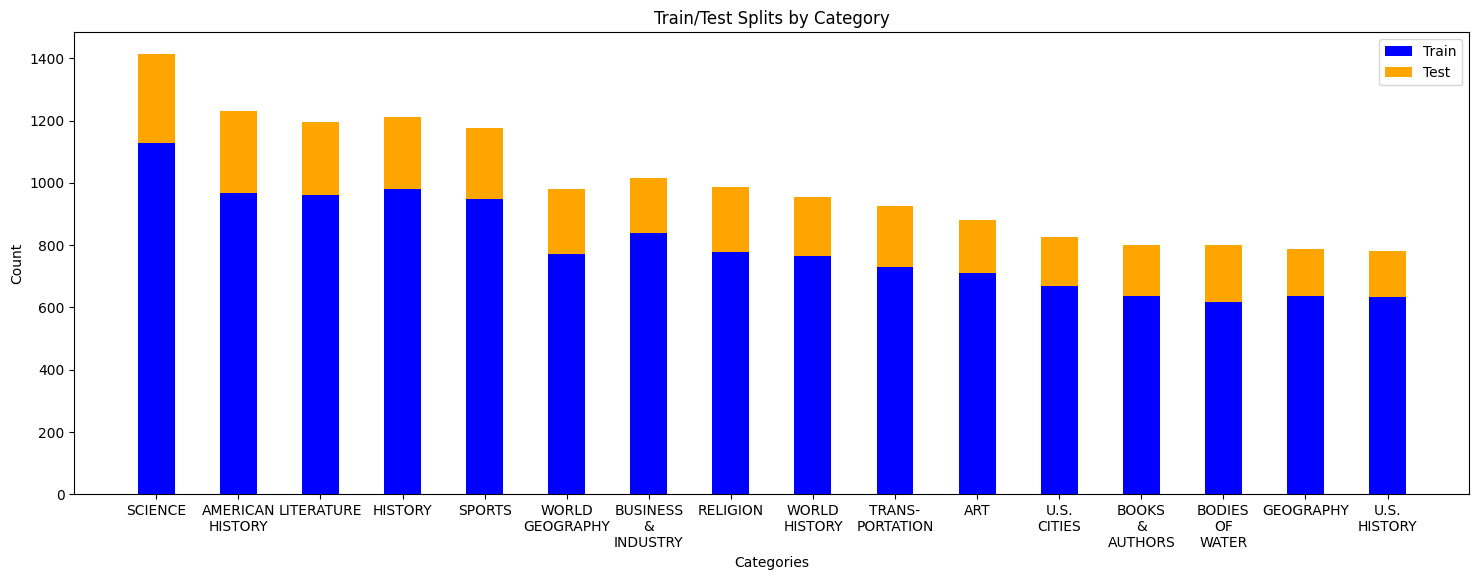

In [ ]:
# Initialize lists to store train and test counts for each category
train_counts = []
test_counts = []

# Iterate over each category
for category in categories_to_test:
    # Count train and test samples for the current category
    train_count = len(train_data[train_data['category'] == category])
    test_count = len(test_data[test_data['category'] == category])

    # Append counts to respective lists
    train_counts.append(train_count)
    test_counts.append(test_count)

# Convert lists to arrays for plotting
train_counts = np.array(train_counts)
test_counts = np.array(test_counts)

# Define the index for the bars
ind = np.arange(len(categories_to_test))

# Define width of bars
width = 0.45

plt.figure(figsize=(18, 6))  # Adjust width and height as needed

# Create the stacked bar chart
plt.bar(ind, train_counts, width, label='Train', color='blue')
plt.bar(ind, test_counts, width, bottom=train_counts, label='Test', color='orange')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Train/Test Splits by Category')
plt.xticks(ind, [cat.replace(" ", "\n").replace("PORTATION", "-\nPORTATION") for cat in categories_to_test])
plt.legend()

# Show plot
plt.show()

In [ ]:
start = time.time()
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training answers
train_answers = train_data['answer'].astype(str).fillna('')  # Convert to string and fill missing values
answer_vectors = vectorizer.fit_transform(train_answers)
print(time.time() - start)

0.24587297439575195


In [ ]:
# Function to find the most similar question based on the answer
def find_similar_question(test_answer, top_n=1):
    # Transform the test answer to the same vector space
    test_vector = vectorizer.transform([test_answer])

    # Calculate cosine similarities between the test vector and all train vectors
    similarities = cosine_similarity(test_vector, answer_vectors)

    # Find the index of the most similar answer
    most_similar_index = similarities.argsort()[0][-top_n:][::-1]

    # Retrieve the corresponding question
    similar_questions = train_data['question'].iloc[most_similar_index]
    similar_scores = similarities[0][most_similar_index]

    # Return the most similar question and its score
    return pd.DataFrame({
        'Question': similar_questions,
        'Score': similar_scores
    })

In [ ]:
# Test the function with a sample answer from the test set
sample_test_answer = test_data['answer'].iloc[0]
similar_questions = find_similar_question(sample_test_answer, top_n=3)
print(f'Test Answer: {sample_test_answer}')
print(similar_questions)
print(test_data['question'].iloc[0])

Test Answer: Indiana city which means "high ground" in French
             Question     Score
30671     Terre Haute  0.688658
68047  a Creole woman  0.290933
66186            Gary  0.283662
Terre Haute


In [ ]:
find_similar_question('The second President of the United States', top_n=1)

,Question,Score
109417,John Adams,0.70082


In [ ]:
find_similar_question('Which NBA team has won the most championships?', top_n=3)

,Question,Score
104198,Boston Celtics,0.584545
81235,the Cleveland Cavaliers,0.549661
269336,the Boston Celtics,0.404076


In [ ]:
find_similar_question('Which NBA team has won the least championships?', top_n=3)

,Question,Score
104198,Boston Celtics,0.584545
81235,the Cleveland Cavaliers,0.549661
269336,the Boston Celtics,0.404076


In [ ]:
def predict_questions_for_test(test_data, top_n=1):
    predictions = []
    for answer in test_data['answer'].astype(str).fillna(''):
        # Transform the test answer to the same vector space
        test_vector = vectorizer.transform([answer])

        # Calculate cosine similarities
        similarities = cosine_similarity(test_vector, answer_vectors)

        # Get the index of the most similar answer
        most_similar_index = similarities.argsort()[0][-top_n:][::-1][0]  # Get only the top 1

        # Retrieve the corresponding question
        predicted_question = train_data['question'].iloc[most_similar_index]
        predictions.append(predicted_question)

    return predictions

In [ ]:
start = time.time()
tfidf_embed_test_predictions = predict_questions_for_test(test_data)
print(time.time() - start)

8.654760837554932


In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], tfidf_embed_test_predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.11949481865284974


In [ ]:
def get_metric_by_category(data, preds, metric):
  test_data = data.reset_index()
  for category in test_data['category'].unique():
    test_data_category = test_data[test_data['category'] == category]
    pred_category = np.array(preds)[test_data_category.index]

    accuracy = metric(test_data_category['question'], pred_category)
    print(f'Category: {category}, Accuracy: {accuracy}')

In [ ]:
get_metric_by_category(test_data, tfidf_embed_test_predictions, accuracy_score)

Category: U.S. CITIES, Accuracy: 0.19863013698630136
Category: SCIENCE, Accuracy: 0.07058823529411765
Category: HISTORY, Accuracy: 0.11864406779661017
Category: SPORTS, Accuracy: 0.052
Category: ART, Accuracy: 0.1366120218579235
Category: WORLD HISTORY, Accuracy: 0.12807881773399016
Category: BOOKS & AUTHORS, Accuracy: 0.1464968152866242
Category: BUSINESS & INDUSTRY, Accuracy: 0.11931818181818182
Category: AMERICAN HISTORY, Accuracy: 0.11904761904761904
Category: U.S. HISTORY, Accuracy: 0.10948905109489052
Category: RELIGION, Accuracy: 0.12222222222222222
Category: WORLD GEOGRAPHY, Accuracy: 0.16176470588235295
Category: LITERATURE, Accuracy: 0.1085972850678733
Category: BODIES OF WATER, Accuracy: 0.20987654320987653
Category: TRANSPORTATION, Accuracy: 0.06748466257668712
Category: GEOGRAPHY, Accuracy: 0.10429447852760736


In [ ]:
def custom_accuracy(preds, test_data):
    total = len(test_data)
    correct = 0
    idx = 0
    for _, row in test_data.iterrows():
        # Check if the predicted question is in the actual question (case insensitive)
        if preds[idx].lower() in row['question'].lower():
            correct += 1

        idx += 1
    return correct / total

In [ ]:
custom_accuracy(tfidf_embed_test_predictions, test_data)

0.15738341968911918

In [ ]:
def get_custom_accuracy_by_category(data, preds):
  test_data = data.reset_index()
  for category in test_data['category'].unique():
    test_data_category = test_data[test_data['category'] == category]
    pred_category = np.array(preds)[test_data_category.index]

    accuracy = custom_accuracy(pred_category, test_data_category)
    print(f'Category: {category}, Accuracy: {accuracy}')

In [ ]:
get_custom_accuracy_by_category(test_data, tfidf_embed_test_predictions)

Category: U.S. CITIES, Accuracy: 0.2191780821917808
Category: SCIENCE, Accuracy: 0.09803921568627451
Category: HISTORY, Accuracy: 0.17372881355932204
Category: SPORTS, Accuracy: 0.076
Category: ART, Accuracy: 0.18579234972677597
Category: WORLD HISTORY, Accuracy: 0.1330049261083744
Category: BOOKS & AUTHORS, Accuracy: 0.1592356687898089
Category: BUSINESS & INDUSTRY, Accuracy: 0.13068181818181818
Category: AMERICAN HISTORY, Accuracy: 0.15476190476190477
Category: U.S. HISTORY, Accuracy: 0.15328467153284672
Category: RELIGION, Accuracy: 0.21666666666666667
Category: WORLD GEOGRAPHY, Accuracy: 0.20588235294117646
Category: LITERATURE, Accuracy: 0.1583710407239819
Category: BODIES OF WATER, Accuracy: 0.25308641975308643
Category: TRANSPORTATION, Accuracy: 0.1165644171779141
Category: GEOGRAPHY, Accuracy: 0.147239263803681


In [ ]:
total = 0
idx = 0
for _, row in test_data.iterrows():
    # Check if the predicted question is in the actual question (case insensitive)
    if tfidf_embed_test_predictions[idx].lower() == row['question'].lower() and tfidf_embed_test_predictions[idx] != row['question']:
      total += 1

    idx += 1

print(total)

24


In [ ]:
idx = 0
total = 0
for _, row in test_data.iterrows():
    # Check if the predicted question is in the actual question (case insensitive)
    if tfidf_embed_test_predictions[idx].lower() in row['question'].lower() and tfidf_embed_test_predictions[idx].lower() != row['question'].lower():
      sample_test_question = row['question']
      sample_test_answer = row['answer']

      print(f'Test Answer: {sample_test_answer}')
      print(f'Question: {sample_test_question}')
      print(tfidf_embed_test_predictions[idx])
      print()
      total += 1

    idx += 1

print(total)

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
Nasser

Test Answer: When this Mongol conqueror was a little boy, his father, Yesugei, was poisoned by Tartars
Question: (Temujin) Genghis Khan
Genghis Khan

Test Answer: It was also known as the Elk Hills scandal, for an oil reserve in California
Question: the Teapot Dome scandal
the Teapot Dome

Test Answer: Little Belt is a strait that separates the island of Fyn from this Danish peninsula
Question: Jutland Peninsula
Jutland

Test Answer: In chapter 2 of this Tolstoy novel, Princess Bolkonsky says, "Tell me what this war is about\"
Question: \"War And Peace\"
War and Peace

Test Answer: This disaster began on October 8, 1871 in a barn on DeKoven Street & left nearly 100,000 people homeless
Question: the Chicago fire
Chicago

Test Answer: The 2 countries that make up the West Indies island of Hispaniola
Question: Haiti & the Dominican Republic


Wrong:

Test Answer: The 1st book of Paul Mark Scott's "Raj Quartet\"
Question: The Jewel in the Crown
the Crown

Test Answer: In the 4th century the Goths split into these two groups
Question: the Visigoths & the Ostrogoths
the Visigoths

Test Answer: The 1st book of Paul Mark Scott's "Raj Quartet\"
Question: The Jewel in the Crown
the Crown

Test Answer: They stretch for about 150 miles from Biscayne Bay into the Gulf of Mexico
Question: the Florida Keys
Florida

In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = find_similar_question(sample_test_answer, top_n=1)
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
          Question     Score
30671  Terre Haute  0.688658

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
            Question     Score
50292  ascorbic acid  0.244305

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
       Question     Score
111596   Nasser  0.328821

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
       Question     Score
211752     fore  0.290826

Test Answer: This Edward Hicks painting is taken from the biblical verse "and the leopard shall lie down with the kid\"
Question: The Peaceable Kingdom
                     Question    Score
392428  The Peaceable Kingdom  0.31411

Test Answer: A reported attack on 2 U.S. destroyers in this gulf led to the passage of th

In [ ]:
for i in range(11, 20):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = find_similar_question(sample_test_answer, top_n=1)
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: The Arabs claim to be descended from his son Ishmael
Question: Abraham
               Question    Score
58121  the Persian Gulf  0.31474

Test Answer: River port of over 600,000 people in the heart of Brazil's Amazon rain forest
Question: Manaus
         Question     Score
45789  the Amazon  0.378427

Test Answer: In 1862 he became Prussia's prime minister under King William I
Question: Bismarck
           Question     Score
69891  Cecil Rhodes  0.358545

Test Answer: George & Lennie have dreams of living off the fat of the land in this Steinbeck tale
Question: Of Mice and Men
              Question     Score
82484  Of Mice and Men  0.416173

Test Answer: Number of days the Arab-Israeli War lasted in June 1967
Question: six days
          Question     Score
7901  Ralph Bunche  0.274991

Test Answer: Coors beer is brewed in this Colorado city
Question: Golden
       Question     Score
114396    Coors  0.698719

Test Answer: Humans have 2 of these long bones, the longest in 

## Embedding Space (BERT)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm.auto import tqdm

In [ ]:
# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# def bert_embed(texts):
#     """Generate BERT embeddings for a list of texts."""
#     # Encode text
#     encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
#     # Compute token embeddings
#     with torch.no_grad():
#         model_output = model(**encoded_input)
#     # Perform mean pooling to get sentence embeddings
#     embeddings = model_output.last_hidden_state
#     attention_mask = encoded_input['attention_mask']
#     mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
#     sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
#     sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
#     return (sum_embeddings / sum_mask).numpy()

In [ ]:
# train_answer_embeddings = bert_embed(train_data['answer'].astype(str).fillna('').tolist())

In [ ]:
def bert_embed(texts, batch_size=32):
    """Generate BERT embeddings for a list of texts using batch processing."""
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare batches
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
    embeddings = []

    for batch in tqdm(batches, desc="Processing batches"):
        # Encode text
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)

        # Compute token embeddings with no gradient calculation
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Perform mean pooling to get sentence embeddings
        batch_embeddings = model_output.last_hidden_state
        attention_mask = encoded_input['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(batch_embeddings.size()).float()
        sum_embeddings = torch.sum(batch_embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()  # Move embeddings to CPU and convert to numpy

        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [ ]:
len(test_data)

3088

In [ ]:
start = time.time()
train_answer_embeddings = bert_embed(train_data['answer'].astype(str).fillna('').tolist(), batch_size=32)
print(time.time() - start)

Processing batches:   0%|          | 0/386 [00:00<?, ?it/s]

26.174922704696655


In [ ]:
# def predict_questions_with_bert(test_data, top_n=1):
#     predictions = []
#     # Embed test answers
#     test_answers = test_data['answer'].astype(str).fillna('')
#     test_answer_embeddings = bert_embed(test_answers.tolist())

#     for test_embedding in test_answer_embeddings:
#         # Calculate cosine similarities with training embeddings
#         similarities = cosine_similarity([test_embedding], train_answer_embeddings)

#         # Get the index of the most similar answer
#         most_similar_index = similarities.argsort()[0][-top_n:][::-1][0]

#         # Retrieve the corresponding question
#         predicted_question = train_data['question'].iloc[most_similar_index]
#         predictions.append(predicted_question)

#     return predictions

In [ ]:
# test_predictions_bert = predict_questions_with_bert(test_data)

In [ ]:
def predict_questions_with_bert(test_data, train_embeddings, train_questions, batch_size=32, top_n = 1):
    predictions = []
    # Embed test answers
    test_answers = test_data['answer'].astype(str).fillna('')
    test_answer_embeddings = bert_embed(test_answers.tolist(), batch_size=batch_size)

    # Process in batches
    test_batches = [test_answer_embeddings[i:i + batch_size] for i in range(0, len(test_answer_embeddings), batch_size)]

    for batch in tqdm(test_batches, desc="Predicting batches"):
        # Calculate cosine similarities for the batch
        similarities = cosine_similarity(batch, train_embeddings)

        # Find the most similar answers for each test embedding in the batch
        for similarity_scores in similarities:
            most_similar_index = similarity_scores.argsort()[-top_n:][::-1][0]
            predicted_question = train_questions.iloc[most_similar_index]
            predictions.append(predicted_question)

    return predictions

In [ ]:
start = time.time()
test_predictions_bert = predict_questions_with_bert(test_data, train_answer_embeddings, train_data['question'], batch_size=32, top_n = 1)
print(time.time() - start)

Processing batches:   0%|          | 0/97 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/97 [00:00<?, ?it/s]

15.15809440612793


In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], test_predictions_bert)
print(f'Accuracy: {accuracy}')

Accuracy: 0.10265544041450778


In [ ]:
get_metric_by_category(test_data, test_predictions_bert, accuracy_score)

Category: U.S. CITIES, Accuracy: 0.11643835616438356
Category: SCIENCE, Accuracy: 0.06666666666666667
Category: HISTORY, Accuracy: 0.1228813559322034
Category: SPORTS, Accuracy: 0.052
Category: ART, Accuracy: 0.14754098360655737
Category: WORLD HISTORY, Accuracy: 0.1477832512315271
Category: BOOKS & AUTHORS, Accuracy: 0.025477707006369428
Category: BUSINESS & INDUSTRY, Accuracy: 0.05113636363636364
Category: AMERICAN HISTORY, Accuracy: 0.11507936507936507
Category: U.S. HISTORY, Accuracy: 0.15328467153284672
Category: RELIGION, Accuracy: 0.12222222222222222
Category: WORLD GEOGRAPHY, Accuracy: 0.1323529411764706
Category: LITERATURE, Accuracy: 0.04524886877828054
Category: BODIES OF WATER, Accuracy: 0.19135802469135801
Category: TRANSPORTATION, Accuracy: 0.06748466257668712
Category: GEOGRAPHY, Accuracy: 0.12269938650306748


In [ ]:
custom_accuracy(test_predictions_bert, test_data)

0.12759067357512954

In [ ]:
get_custom_accuracy_by_category(test_data, test_predictions_bert)

Category: U.S. CITIES, Accuracy: 0.1232876712328767
Category: SCIENCE, Accuracy: 0.08627450980392157
Category: HISTORY, Accuracy: 0.16101694915254236
Category: SPORTS, Accuracy: 0.064
Category: ART, Accuracy: 0.18579234972677597
Category: WORLD HISTORY, Accuracy: 0.15270935960591134
Category: BOOKS & AUTHORS, Accuracy: 0.025477707006369428
Category: BUSINESS & INDUSTRY, Accuracy: 0.05113636363636364
Category: AMERICAN HISTORY, Accuracy: 0.15079365079365079
Category: U.S. HISTORY, Accuracy: 0.18248175182481752
Category: RELIGION, Accuracy: 0.18333333333333332
Category: WORLD GEOGRAPHY, Accuracy: 0.14215686274509803
Category: LITERATURE, Accuracy: 0.06334841628959276
Category: BODIES OF WATER, Accuracy: 0.24691358024691357
Category: TRANSPORTATION, Accuracy: 0.1165644171779141
Category: GEOGRAPHY, Accuracy: 0.147239263803681


In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = test_predictions_bert[i]
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
Pueblo

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
turtle/tortoise

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
(Alexander) Dubček

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
fore

Test Answer: This Edward Hicks painting is taken from the biblical verse "and the leopard shall lie down with the kid\"
Question: The Peaceable Kingdom
Ogden Nash

Test Answer: A reported attack on 2 U.S. destroyers in this gulf led to the passage of the 1964 resolution named for it
Question: the Gulf of Tonkin
Germany

Test Answer: His title "The Sound and the Fury" was taken from Shakespeare's "Macbeth\"
Question: (William) Faulkner
Somerset Maugham

Test Answer: This Japanese co. famous fo

## Zero-Shot T5

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [ ]:
def setup_model(model_name='t5-base'):
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    return model, tokenizer

In [ ]:
def generate_question(answer, model, tokenizer):
    # Reformulate the prompt to be more specific and control output generation better.
    input_ids = tokenizer.encode(answer, return_tensors='pt')

    # Configure model to generate with more flexibility and prevent cut-off answers.
    outputs = model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, temperature=0.9)

    question = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return question

In [ ]:
model, tokenizer = setup_model()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
test_predictions_bert_zero_shot = []

In [ ]:
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing"):
    pred = generate_question(row['answer'], model, tokenizer)
    test_predictions_bert_zero_shot.append(pred)

Processing:   0%|          | 0/3088 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


KeyboardInterrupt: 

 19/3088 [00:30<1:20:45,  1.58s/it]

In [ ]:
test_predictions_bert_zero_shot

In [ ]:
len(test_data)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], test_predictions_bert_zero_shot)
print(f'Accuracy: {accuracy}')

In [ ]:
get_metric_by_category(test_data, test_predictions_bert_zero_shot, accuracy_score)

In [ ]:
custom_accuracy(test_predictions_bert_zero_shot, test_data)

In [ ]:
get_custom_accuracy_by_category(test_data, test_predictions_bert_zero_shot)

In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = test_predictions_bert_zero_shot[i]
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
which means "high ground" in French, Indiana city which literally means high ground in Indiana. Indiana is a city in the state of Indiana which is "the highest ground".

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
a dietary source of this vitamin, also called ascorbic acid.. Like humans, the Red-vented Bulbul bird needs supplemental folic acid, or aspartic acid. The Red Bul Bulbull bird also needs ascobic acids, aka aspirin. Ascorbacin is derived from the phosphorus niacillin, which is found in the body of the bird.

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
the Egyptian president.. coup has succeeded; time for the group photo with these two future presidents in it. The 1952 Egyptian coup succeeded. Time for a g

## Zero-Shot BERT Classification

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline("zero-shot-classification", model="bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
def zero_shot_predict(answer, candidate_questions):
    # hypothesis_template = "The question related to this answer is: {}"
    # # Format each question in the list of candidate questions
    # formatted_questions = [hypothesis_template.format(question) for question in candidate_questions]

    # Use the classifier to predict
    result = classifier(answer, candidate_questions, multi_label=True)
    return result

In [ ]:
candidate_questions = train_data['question'].unique()

In [ ]:
from tqdm import tqdm

In [ ]:
# # Iterate over the DataFrame rows with tqdm for progress tracking
# for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing"):
#     pred = zero_shot_predict(row['answer'], candidate_questions)
#     test_predictions_bert_zero_shot.append(pred)

Processing:   0%|          | 0/3088 [00:38<?, ?it/s]


KeyboardInterrupt: 

## Fine-Tune BERT

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [ ]:
import torch

In [ ]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class JeopardyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def tokenize_and_encode(data):
    input_encodings = tokenizer(data['answer'].tolist(), truncation=True, padding=True, max_length=512)
    # Convert labels (questions) to ids
    label_encodings = data['label'].tolist()
    return input_encodings, label_encodings

In [ ]:
# Map questions to unique ids
unique_questions = data['question'].unique()
question_to_id = {q: i for i, q in enumerate(unique_questions)}
# data['label'] = data['question'].map(question_to_id)

In [ ]:
train_data['label'] = train_data['question'].map(question_to_id)

# Should just end up predicting the train ones but need to tokenize
test_data['label'] = test_data['question'].map(question_to_id)

In [ ]:
# Tokenize and encode
train_encodings, train_labels = tokenize_and_encode(train_data)
test_encodings, test_labels = tokenize_and_encode(test_data)

In [ ]:
# Create datasets
train_dataset_jeopardy = JeopardyDataset(train_encodings, train_labels)
test_dataset_jeopardy = JeopardyDataset(test_encodings, test_labels)

In [ ]:
# Load the BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_questions))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_jeopardy,
    eval_dataset=test_dataset_jeopardy
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,8.800700,8.737650
2,8.498000,8.869258
3,8.269300,9.169024


TrainOutput(global_step=4632, training_loss=8.565999665202666, metrics={'train_runtime': 973.4763, 'train_samples_per_second': 38.066, 'train_steps_per_second': 4.758, 'total_flos': 2504011683239424.0, 'train_loss': 8.565999665202666, 'epoch': 3.0})

In [ ]:
# results = trainer.evaluate()

In [ ]:
# Use model to predict
test_prediction_output = trainer.predict(test_dataset_jeopardy)

In [ ]:
import numpy as np

In [ ]:
# Extract logits from the prediction output
logits = test_prediction_output.predictions

# Apply softmax to logits to get probabilities
probabilities = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()

# Get the predicted labels (indices of the maximum values)
predicted_indices = np.argmax(probabilities, axis=1)

In [ ]:
id_to_question = {v: k for k, v in question_to_id.items()}

In [ ]:
predicted_questions_fine_tuned = [id_to_question[idx] for idx in predicted_indices]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], predicted_questions_fine_tuned)
print(f'Accuracy: {accuracy}')

Accuracy: 0.005505181347150259


In [ ]:
get_metric_by_category(test_data, predicted_questions_fine_tuned, accuracy_score)

Category: U.S. CITIES, Accuracy: 0.0
Category: SCIENCE, Accuracy: 0.0
Category: HISTORY, Accuracy: 0.00423728813559322
Category: SPORTS, Accuracy: 0.008
Category: ART, Accuracy: 0.03278688524590164
Category: WORLD HISTORY, Accuracy: 0.0
Category: BOOKS & AUTHORS, Accuracy: 0.006369426751592357
Category: BUSINESS & INDUSTRY, Accuracy: 0.0
Category: AMERICAN HISTORY, Accuracy: 0.0
Category: U.S. HISTORY, Accuracy: 0.0
Category: RELIGION, Accuracy: 0.0
Category: WORLD GEOGRAPHY, Accuracy: 0.0196078431372549
Category: LITERATURE, Accuracy: 0.0
Category: BODIES OF WATER, Accuracy: 0.0
Category: TRANSPORTATION, Accuracy: 0.0
Category: GEOGRAPHY, Accuracy: 0.018404907975460124


In [ ]:
custom_accuracy(predicted_questions_fine_tuned, test_data)

0.005829015544041451

In [ ]:
get_custom_accuracy_by_category(test_data, predicted_questions_fine_tuned)

Category: U.S. CITIES, Accuracy: 0.0
Category: SCIENCE, Accuracy: 0.0
Category: HISTORY, Accuracy: 0.00423728813559322
Category: SPORTS, Accuracy: 0.008
Category: ART, Accuracy: 0.03278688524590164
Category: WORLD HISTORY, Accuracy: 0.0
Category: BOOKS & AUTHORS, Accuracy: 0.006369426751592357
Category: BUSINESS & INDUSTRY, Accuracy: 0.0
Category: AMERICAN HISTORY, Accuracy: 0.0
Category: U.S. HISTORY, Accuracy: 0.0
Category: RELIGION, Accuracy: 0.0
Category: WORLD GEOGRAPHY, Accuracy: 0.0196078431372549
Category: LITERATURE, Accuracy: 0.0
Category: BODIES OF WATER, Accuracy: 0.0
Category: TRANSPORTATION, Accuracy: 0.006134969325153374
Category: GEOGRAPHY, Accuracy: 0.018404907975460124


In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = predicted_questions_fine_tuned[i]
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
Australia

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
Michael Jordan

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
Michael Jordan

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
the House of the Seven Gables

Test Answer: This Edward Hicks painting is taken from the biblical verse "and the leopard shall lie down with the kid\"
Question: The Peaceable Kingdom
Michael Jordan

Test Answer: A reported attack on 2 U.S. destroyers in this gulf led to the passage of the 1964 resolution named for it
Question: the Gulf of Tonkin
Australia

Test Answer: His title "The Sound and the Fury" was taken from Shakespeare's "Macbeth\"
Question: (William) Faulkner
Salvador Dali

Test Answer: T

## BERT to Predict Embeddings

In [ ]:
from transformers import BertModel, BertConfig
from torch.utils.data import DataLoader, Dataset

In [ ]:
class BertForEmbedding(torch.nn.Module):
    def __init__(self, model_name):
        super(BertForEmbedding, self).__init__()
        config = BertConfig.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name, config=config)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Using the pooled output of the [CLS] token
        return pooled_output

In [ ]:
model = BertForEmbedding('distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.l

In [ ]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [ ]:
loss_fn = TripletLoss(margin=1.0)

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        return self.triplets[idx]

In [ ]:
def create_triplets(data):
    triplets = []
    for idx, row in data.iterrows():
        answer = row['answer']
        correct_question = row['question']
        # Select a random incorrect question
        incorrect_question = data[data['question'] != correct_question].sample(1)['question'].values[0]
        triplets.append((answer, correct_question, incorrect_question))
    return triplets

In [ ]:
# def create_triplets_tensors(data):
#     triplets = []
#     for idx in range(len(data)):
#         answer = data['answer'][idx]
#         correct_question = data['question'][idx]
#         incorrect_question = data[data['question'] != correct_question].sample(1)['question'].values[0]
#         triplets.append((answer, correct_question, incorrect_question))
#     return triplets

In [ ]:
triplets = create_triplets(data)

In [ ]:
# triplets = torch.Tensor(triplets)

In [ ]:
train_dataset = TripletDataset(triplets)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
num_epochs = 2

In [ ]:
def prepare_input(text):
    encoded = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }

In [ ]:
from tqdm import tqdm

In [ ]:
model.train()
for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = [prepare_input(text) for triplet in batch for text in triplet]
        embeddings = [model(**input) for input in inputs]

        # Reorganize embeddings based on triplets
        answer_embeddings, correct_embeddings, incorrect_embeddings = embeddings[::3], embeddings[1::3], embeddings[2::3]

        # Compute triplet loss for batch
        loss = torch.mean(torch.stack([loss_fn(a, c, i) for a, c, i in zip(answer_embeddings, correct_embeddings, incorrect_embeddings)]))

        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

Epoch 0:   0%|          | 0/965 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 0:   4%|▍         | 39/965 [04:39<1:50:45,  7.18s/it, loss=1.49]


KeyboardInterrupt: 

In [ ]:
def embed_questions(model, questions):
    model.eval()
    question_embeddings = []
    for question in tqdm(questions, desc="Embedding questions"):
        input = prepare_input(question)
        with torch.no_grad():
            embedding = model(**input).cpu().numpy()
        question_embeddings.append(embedding)
    return np.vstack(question_embeddings)

In [ ]:
all_questions = np.array(list(set(train_data['question'].tolist())))
question_embeddings = embed_questions(model, all_questions)

Embedding questions: 100%|██████████| 7385/7385 [04:17<00:00, 28.63it/s]


In [ ]:
def embed_answers(model, answers):
    model.eval()
    answer_embeddings = []
    for answer in tqdm(answers, desc="Embedding answers"):
        input = prepare_input(answer)
        with torch.no_grad():
            embedding = model(**input).cpu().numpy()
        answer_embeddings.append(embedding)
    return np.vstack(answer_embeddings)

In [ ]:
test_answers = test_data['answer'].tolist()
test_answer_embeddings = embed_answers(model, test_answers)

Embedding answers: 100%|██████████| 3088/3088 [03:36<00:00, 14.25it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def find_most_similar_questions(answer_embeddings, question_embeddings, questions):
    similarities = cosine_similarity(answer_embeddings, question_embeddings)
    most_similar_indices = np.argmax(similarities, axis=1)
    return questions[most_similar_indices], np.max(similarities, axis=1)

In [ ]:
predicted_questions, scores = find_most_similar_questions(test_answer_embeddings, question_embeddings, all_questions)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], predicted_questions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.0


In [ ]:
get_metric_by_category(test_data, predicted_questions, accuracy_score)

Category: U.S. CITIES, Accuracy: 0.0
Category: SCIENCE, Accuracy: 0.0
Category: HISTORY, Accuracy: 0.0
Category: SPORTS, Accuracy: 0.0
Category: ART, Accuracy: 0.0
Category: WORLD HISTORY, Accuracy: 0.0
Category: BOOKS & AUTHORS, Accuracy: 0.0
Category: BUSINESS & INDUSTRY, Accuracy: 0.0
Category: AMERICAN HISTORY, Accuracy: 0.0
Category: U.S. HISTORY, Accuracy: 0.0
Category: RELIGION, Accuracy: 0.0
Category: WORLD GEOGRAPHY, Accuracy: 0.0
Category: LITERATURE, Accuracy: 0.0
Category: BODIES OF WATER, Accuracy: 0.0
Category: TRANSPORTATION, Accuracy: 0.0
Category: GEOGRAPHY, Accuracy: 0.0


In [ ]:
custom_accuracy(predicted_questions, test_data)

0.0

In [ ]:
get_custom_accuracy_by_category(test_data, predicted_questions)

Category: U.S. CITIES, Accuracy: 0.0
Category: SCIENCE, Accuracy: 0.0
Category: HISTORY, Accuracy: 0.0
Category: SPORTS, Accuracy: 0.0
Category: ART, Accuracy: 0.0
Category: WORLD HISTORY, Accuracy: 0.0
Category: BOOKS & AUTHORS, Accuracy: 0.0
Category: BUSINESS & INDUSTRY, Accuracy: 0.0
Category: AMERICAN HISTORY, Accuracy: 0.0
Category: U.S. HISTORY, Accuracy: 0.0
Category: RELIGION, Accuracy: 0.0
Category: WORLD GEOGRAPHY, Accuracy: 0.0
Category: LITERATURE, Accuracy: 0.0
Category: BODIES OF WATER, Accuracy: 0.0
Category: TRANSPORTATION, Accuracy: 0.0
Category: GEOGRAPHY, Accuracy: 0.0


In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = predicted_questions[i]
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
\"The Hitman" Thomas Hearns

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
(2 of) Chihuahua, Coahuila, Tamaulipas, Baja California Norte, Sonora & Nuevo León

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
Chile (which goes down around Tierra Del Fuego & sweeps a little south of Argentina)

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
(2 of) Chihuahua, Coahuila, Tamaulipas, Baja California Norte, Sonora & Nuevo León

Test Answer: This Edward Hicks painting is taken from the biblical verse "and the leopard shall lie down with the kid\"
Question: The Peaceable Kingdom
(2 of) Chihuahua, Coahuila, Tamaulipas, Baja California Norte, Sonora & Nuevo León

Test Answer: A reported attac

## Siamese Networks

## ChatGPT API

In [ ]:
!pip install openai

In [ ]:
import openai

In [ ]:
system_prompt = {"role": "system", "content": "You are a Jeopardy contestant. Respond to each answer with a formatted question as it would appear in Jeopardy, but without the question word (e.g. What is). "}

In [ ]:
client = openai.OpenAI(api_key=api_key)

In [ ]:
from tqdm import tqdm

In [ ]:
predicted_questions_gpt = []

# Wrap your loop with tqdm
for answer in tqdm(test_data['answer'], desc="Generating questions"):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                system_prompt,
                {"role": "user", "content": answer}
            ]
        )
        # Extract the content of the response assuming the last message is from the assistant
        predicted_question = response.choices[0].message.content
        predicted_questions.append(predicted_question)
    except Exception as e:
        print(f"Error processing answer '{answer}': {str(e)}")
        predicted_questions.append("")

Generating questions: 100%|██████████| 3088/3088 [29:46<00:00,  1.73it/s]


In [ ]:
predicted_questions_gpt = predicted_questions.copy()

In [ ]:
predicted_questions_gpt = predicted_questions_gpt[2:]

In [ ]:
pd.DataFrame(predicted_questions_gpt, columns=['GPT-Question']).to_csv('gpt_questions.csv')

In [ ]:
cleaned_questions = []

for question in predicted_questions_gpt:
  cleaned_question = (" ".join(question.split(' ')[2:])).replace("?", "").replace("\"", "")
  cleaned_questions.append(cleaned_question)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_data['question'], cleaned_questions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5042098445595855


In [ ]:
get_metric_by_category(test_data, cleaned_questions, accuracy_score)

Category: U.S. CITIES, Accuracy: 0.7054794520547946
Category: SCIENCE, Accuracy: 0.5098039215686274
Category: HISTORY, Accuracy: 0.4957627118644068
Category: SPORTS, Accuracy: 0.472
Category: ART, Accuracy: 0.3879781420765027
Category: WORLD HISTORY, Accuracy: 0.5270935960591133
Category: BOOKS & AUTHORS, Accuracy: 0.5605095541401274
Category: BUSINESS & INDUSTRY, Accuracy: 0.4318181818181818
Category: AMERICAN HISTORY, Accuracy: 0.5555555555555556
Category: U.S. HISTORY, Accuracy: 0.39416058394160586
Category: RELIGION, Accuracy: 0.4777777777777778
Category: WORLD GEOGRAPHY, Accuracy: 0.5441176470588235
Category: LITERATURE, Accuracy: 0.5927601809954751
Category: BODIES OF WATER, Accuracy: 0.4074074074074074
Category: TRANSPORTATION, Accuracy: 0.38650306748466257
Category: GEOGRAPHY, Accuracy: 0.588957055214724


In [ ]:
custom_accuracy(cleaned_questions, test_data)

0.5456606217616581

In [ ]:
get_custom_accuracy_by_category(test_data, cleaned_questions)

Category: U.S. CITIES, Accuracy: 0.726027397260274
Category: SCIENCE, Accuracy: 0.5568627450980392
Category: HISTORY, Accuracy: 0.5127118644067796
Category: SPORTS, Accuracy: 0.524
Category: ART, Accuracy: 0.47540983606557374
Category: WORLD HISTORY, Accuracy: 0.5566502463054187
Category: BOOKS & AUTHORS, Accuracy: 0.6050955414012739
Category: BUSINESS & INDUSTRY, Accuracy: 0.4659090909090909
Category: AMERICAN HISTORY, Accuracy: 0.5912698412698413
Category: U.S. HISTORY, Accuracy: 0.4233576642335766
Category: RELIGION, Accuracy: 0.5277777777777778
Category: WORLD GEOGRAPHY, Accuracy: 0.5784313725490197
Category: LITERATURE, Accuracy: 0.669683257918552
Category: BODIES OF WATER, Accuracy: 0.42592592592592593
Category: TRANSPORTATION, Accuracy: 0.43558282208588955
Category: GEOGRAPHY, Accuracy: 0.6134969325153374


In [ ]:
def custom_accuracy_bijective(preds, test_data):
    total = len(test_data)
    correct = 0
    idx = 0
    for _, row in test_data.iterrows():
        # Check if the predicted question is in the actual question (case insensitive)
        question = row['question'].lower().replace('(', '').replace(')', '')
        # if preds[idx].lower() in question.lower() or question.lower() in preds[idx].lower():
        if preds[idx].lower() in question.lower() or question.lower() in preds[idx].lower() or all(word.lower() in question.split() for word in preds[idx].lower().split()) or all(word.lower() in preds[idx].lower().split() for word in question.lower().split()):
            correct += 1

        idx += 1
    return correct / total

In [ ]:
def get_custom_accuracy_bijective_by_category(data, preds):
  test_data = data.reset_index()
  for category in test_data['category'].unique():
    test_data_category = test_data[test_data['category'] == category]
    pred_category = np.array(preds)[test_data_category.index]

    accuracy = custom_accuracy_bijective(pred_category, test_data_category)
    print(f'Category: {category}, Accuracy: {accuracy}')

In [ ]:
custom_accuracy_bijective(cleaned_questions, test_data)

0.7636010362694301

In [ ]:
get_custom_accuracy_bijective_by_category(test_data, cleaned_questions)

Category: U.S. CITIES, Accuracy: 0.7945205479452054
Category: SCIENCE, Accuracy: 0.8196078431372549
Category: HISTORY, Accuracy: 0.7372881355932204
Category: SPORTS, Accuracy: 0.72
Category: ART, Accuracy: 0.7650273224043715
Category: WORLD HISTORY, Accuracy: 0.7881773399014779
Category: BOOKS & AUTHORS, Accuracy: 0.821656050955414
Category: BUSINESS & INDUSTRY, Accuracy: 0.6363636363636364
Category: AMERICAN HISTORY, Accuracy: 0.7777777777777778
Category: U.S. HISTORY, Accuracy: 0.7518248175182481
Category: RELIGION, Accuracy: 0.7666666666666667
Category: WORLD GEOGRAPHY, Accuracy: 0.7843137254901961
Category: LITERATURE, Accuracy: 0.8506787330316742
Category: BODIES OF WATER, Accuracy: 0.7962962962962963
Category: TRANSPORTATION, Accuracy: 0.6687116564417178
Category: GEOGRAPHY, Accuracy: 0.7055214723926381


In [ ]:
for i in range(10):
  # Test the function with a sample answer from the test set
  sample_test_answer = test_data['answer'].iloc[i]
  sample_test_question = test_data['question'].iloc[i]

  similar_questions = predicted_questions_gpt[i]
  print(f'Test Answer: {sample_test_answer}')
  print(f'Question: {sample_test_question}')
  print(similar_questions)
  print()

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
What is Fort Wayne?

Test Answer: Like humans, the Red-vented Bulbul bird needs a dietary source of this vitamin, also called ascorbic acid
Question: Vitamin C
What is vitamin C?

Test Answer: The 1952 Egyptian coup has succeeded; time for the group photo with these two future presidents in it
Question: Nasser and Sadat
Who are Gamal Abdel Nasser and Anwar Sadat?

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
What is missed the ball entirely without making contact?

Test Answer: This Edward Hicks painting is taken from the biblical verse "and the leopard shall lie down with the kid\"
Question: The Peaceable Kingdom
What is "The Peaceable Kingdom"?

Test Answer: A reported attack on 2 U.S. destroyers in this gulf led to the passage of the 1964 resolution named for it
Question: the Gulf of Tonkin
What is the Gulf of Tonkin?

Test Answer: His title "The Sound and th

In [ ]:
idx = 0
total = 0

for _, row in test_data.iterrows():
    if total == 50:
      break

    # Check if the predicted question is in the actual question (case insensitive)
    question = row['question'].lower().replace('(', '').replace(')', '')
    if not (cleaned_questions[idx].lower() in question.lower() or question.lower() in cleaned_questions[idx].lower() or all(word.lower() in question.split() for word in cleaned_questions[idx].lower().split()) or all(word.lower() in cleaned_questions[idx].lower().split() for word in question.lower().split())):
      sample_test_question = row['question']
      sample_test_answer = row['answer']

      print(f'Test Answer: {sample_test_answer}')
      print(f'Question: {sample_test_question}')
      print(cleaned_questions[idx])
      print()
      total += 1

    idx += 1

print(total)

Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
Fort Wayne

Test Answer: In golf, a "whiff" means you've done this to the ball
Question: missed it
missed the ball entirely without making contact

Test Answer: Humans have 2 of these long bones, the longest in the body
Question: a femur
femurs

Test Answer: There are 2 Cagayan Rivers in this country, one on Luzon, the other on Mindanao
Question: the Philippines
is home to the 2 Cagayan Rivers, one located on Luzon and the other on Mindanao

Test Answer: Canada's "Great Bear" one covers over 12,000 square miles
Question: a lake
the Great Bear Rainforest

Test Answer: Bartlett's says this courtesan, not the king, said, "Apres nous, le deluge\"
Question: Madame du Pompadour
Madame de Pompadour

Test Answer: In the mid-1500s Akbar the Great, son of Humayun, ruler of Delhi, reigned over this empire in India
Question: the Mogul Empire
the Mughal Empire

Test Answer: A sura is one of the chapters or sections 

In [ ]:
test_data['category'].unique()

array(['U.S. CITIES', 'SCIENCE', 'HISTORY', 'SPORTS', 'ART',
       'WORLD HISTORY', 'BOOKS & AUTHORS', 'BUSINESS & INDUSTRY',
       'AMERICAN HISTORY', 'U.S. HISTORY', 'RELIGION', 'WORLD GEOGRAPHY',
       'LITERATURE', 'BODIES OF WATER', 'TRANSPORTATION', 'GEOGRAPHY'],
      dtype=object)

In [ ]:
test_data['category'].unique()

array(['U.S. CITIES', 'SCIENCE', 'HISTORY', 'SPORTS', 'ART',
       'WORLD HISTORY', 'BOOKS & AUTHORS', 'BUSINESS & INDUSTRY',
       'AMERICAN HISTORY', 'U.S. HISTORY', 'RELIGION', 'WORLD GEOGRAPHY',
       'LITERATURE', 'BODIES OF WATER', 'TRANSPORTATION', 'GEOGRAPHY'],
      dtype=object)

In [ ]:
for category in test_data['category'].unique():
  print(category)
  total = 0
  reset = test_data.reset_index()
  for idx, row in reset[reset['category'] == category].iterrows():
      if total == 10:
        break

      # Check if the predicted question is in the actual question (case insensitive)
      question = row['question'].lower().replace('(', '').replace(')', '')
      if not (cleaned_questions[idx].lower() in question.lower() or question.lower() in cleaned_questions[idx].lower() or all(word.lower() in question.split() for word in cleaned_questions[idx].lower().split()) or all(word.lower() in cleaned_questions[idx].lower().split() for word in question.lower().split())):
        sample_test_question = row['question']
        sample_test_answer = row['answer']

        print(f'Test Answer: {sample_test_answer}')
        print(f'Question: {sample_test_question}')
        print(cleaned_questions[idx])
        print()
        total += 1

      idx += 1

  print("*********************************************************************************************************")

U.S. CITIES
Test Answer: Indiana city which means "high ground" in French
Question: Terre Haute
Fort Wayne

Test Answer: It was laid out according to Joseph Smith's plan for the city of Zion, with a temple in the center
Question: Salt Lake City
Independence, Missouri

Test Answer: New England city in which about 1850, Ephraim W. Bull developed a popular table grape
Question: Concord
Worcester, Massachusetts

Test Answer: City in which this opera takes place: Instrumental music plays... "Summertime, and the livin' is easy...\"
Question: Charleston, South Carolina
the city of Porgy and Bess, where the song Summertime is famously set

Test Answer: D.H. Lawrence lived & Kit Carson was buried in this northern New Mexico city
Question: Taos
Santa Fe

Test Answer: Arlington is located between these third & sixth most populous cities in Texas
Question: Dallas & Fort Worth
Fort Worth and Dallas

Test Answer: This state has cities named after the Burling family Benning Wentworth
Question: Vermon

In [ ]:
idx = 0
total = 0

for _, row in test_data.iterrows():
    if total == 50:
      break

    # Check if the predicted question is in the actual question (case insensitive)
    if cleaned_questions[idx].lower() not in row['question'].lower() and row['question'].lower() in cleaned_questions[idx].lower():
      sample_test_question = row['question']
      sample_test_answer = row['answer']

      print(f'Test Answer: {sample_test_answer}')
      print(f'Question: {sample_test_question}')
      print(cleaned_questions[idx])
      print()
      total += 1

    idx += 1

print(total)

Test Answer: In 1862 he became Prussia's prime minister under King William I
Question: Bismarck
Otto von Bismarck

Test Answer: New & unknown in Paris, at 22 he painted "The Old Guitarist" in shades of blue that reflected his mood
Question: Picasso
Pablo Picasso

Test Answer: The freighting firm of Russell, Majors & Waddell began this short-lived U.S. mail delivery service in 1860
Question: Pony Express
the Pony Express

Test Answer: A cruise on this sea might include stops in St. Thomas, Puerto Rico & Martinique
Question: the Caribbean
the Caribbean Sea

Test Answer: The basin of this most sacred Hindu river is one of the world's most populous regions
Question: the Ganges
the Ganges River

Test Answer: Roman Catholics are married at this kind of mass
Question: nuptial mass
a Nuptial Mass

Test Answer: This salt company's "Umbrella Girl" is one of the most famous brand icons in the United States
Question: Morton
Morton Salt

Test Answer: The "Thinker" guards the entrance to the Philade

## Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        nopeak_mask = nopeak_mask.to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## ChatGPT API In-Context Learning

In [ ]:
# Sample a few training examples to use as context
training_samples = [
    {"answer": "George Washington", "question": "Who was the first president of the United States?"},
    {"answer": "Pacific", "question": "What is the largest ocean on Earth?"},
    {"answer": "Shakespeare", "question": "Who wrote Hamlet?"},
    {"answer": "Python", "question": "What programming language is known for its readability?"},
    {"answer": "Mt. Everest", "question": "What is the highest mountain in the world?"}
]


In [ ]:
# Create a prompt with examples
context_messages = [{"role": "system", "content": "You are a Jeopardy contestant. Convert the provided answer into a correctly formatted question as seen in Jeopardy."}]
for sample in training_samples:
    context_messages.append({"role": "user", "content": sample['answer']})
    context_messages.append({"role": "assistant", "content": sample['question']})

In [ ]:
from tqdm import tqdm

predicted_questions_gpt = []

# Use tqdm for progress bar
for answer in tqdm(test_data['answer'], desc="Generating questions"):
    messages = context_messages.copy()  # Copy the context
    messages.append({"role": "user", "content": answer})  # Add the current test answer to the context

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages
        )
        # Assume the model's response is the last message
        predicted_question = response['choices'][0]['message']['content']
        predicted_questions_gpt.append(predicted_question)
    except Exception as e:
        print(f"Error processing answer '{answer}': {str(e)}")
        predicted_questions_gpt.append("")

# Optionally, you can now save or process these predictions as needed.
